In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

q = Query.objects.get(pk=2355)

hot_docs = Doc.objects.filter(query=q,wosarticle__tc__isnull=False).order_by('-wosarticle__tc')[:100]


#doc = Doc.objects.get(pk=)
#topic = Topic.objects.get(pk=)
stat = RunStats.objects.get(pk=662)

In [2]:
hot_doc_tab = pd.DataFrame.from_dict(list(hot_docs.values('id','title','authors','wosarticle__tc','PY')))

hot_doc_tab.head(14)

,PY,authors,id,title,wosarticle__tc
0,2005,"Arico, AS, Bruce, P, Scrosati, B, Tarascon, JM...",671811,Nanostructured materials for advanced energy c...,4501
1,2002,"Walther, GR, Post, E, Convey, P, Menzel, A, Pa...",536594,Ecological responses to recent climate change,4476
2,2006,"Phillips, SJ, Anderson, RP, Schapire, RE",461474,Maximum entropy modeling of species geographic...,4407
3,2003,"Parmesan, C, Yohe, G",578042,A globally coherent fingerprint of climate cha...,4300
4,2001,"Zachos, J, Pagani, M, Sloan, L, Thomas, E, Bil...",42709,"Trends, rhythms, and aberrations in global cli...",4127
5,2007,"Chisti, Y, Chisti, Y",69164,Biodiesel from microalgae,3525
6,2003,"Rayner, NA, Parker, DE, Horton, EB, Folland, C...",408552,"Global analyses of sea surface temperature, se...",3479
7,1997,"Mantua, NJ, Hare, SR, Zhang, Y, Wallace, JM, F...",25916,A Pacific interdecadal climate oscillation wit...,3368
8,1992,"LEVIN, SA",94906,THE PROBLEM OF PATTERN AND SCALE IN ECOLOGY,3302
9,2000,"Sala, OE, Chapin, FS, Armesto, JJ, Berlow, E, ...",188209,Biodiversity - Global biodiversity scenarios f...,3272


In [3]:
tcs = Doc.objects.filter(
    query=stat.query,wosarticle__tc__isnull=False,
    #wosarticle__tc__gt=0
).values('wosarticle__tc')

tcs = pd.DataFrame(list(tcs))
tcs.head()

,wosarticle__tc
0,2
1,212
2,3
3,4
4,23


In [4]:
iptcs = Doc.objects.filter(
    query=stat.query,wosarticle__tc__isnull=False,
    ipccref__isnull=False
).values('wosarticle__tc')
iptcs = pd.DataFrame(list(iptcs))
iptcs['log_IPCC'] = np.log1p(iptcs['wosarticle__tc'])
iptcs.head()

,wosarticle__tc,log_IPCC
0,159,5.075174
1,159,5.075174
2,11,2.484907
3,11,2.484907
4,48,3.891820


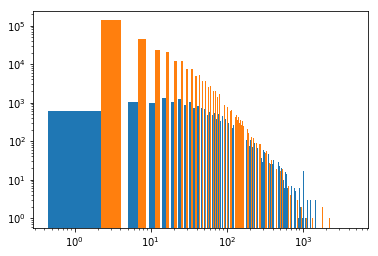

In [5]:
#iptcs['wosarticle__tc'].hist(bins=1000)

#tcs['wosarticle__tc'].hist(bins=1000)

plt.hist([iptcs['wosarticle__tc'],tcs['wosarticle__tc']],1000,label=['IPCC','all'])

plt.xscale('log')
plt.yscale('log')

plt.show()

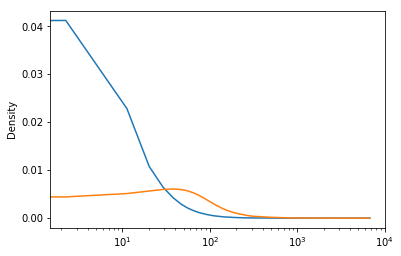

In [79]:
from matplotlib import transforms

# first of all, the base transformation of the data points is needed
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(90)

tcs['wosarticle__tc'].plot.density()#transform = rot + base)

iptcs['wosarticle__tc'].plot.density()#transform = rot + base)

plt.xscale('log')

plt.show()

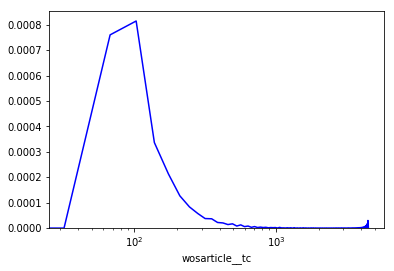

In [51]:
import seaborn as sns

#sns.distplot([iptcs['wosarticle__tc'],tcs['wosarticle__tc']], hist=False, kde=True, 
             
sns.distplot(tcs['wosarticle__tc'], hist=False, 
             kde_kws = {
                 'clip':[0,50000],
             },
             kde=True, 
             color = 'blue'#,
             #kde_kws={'bw':100}
            )

#sns.distplot(iptcs['wosarticle__tc'], hist=False, 
#             kde_kws = {
#                 'clip':[0,5000],
#             },
#             color = 'blue',
#             #kde_kws={'bw':100}
#            )
# Add labels
#plt.title('Histogram of Arrival Delays')
#plt.xlabel('Delay (min)')
#plt.ylabel('Flights')

plt.xscale('log')

plt.show()

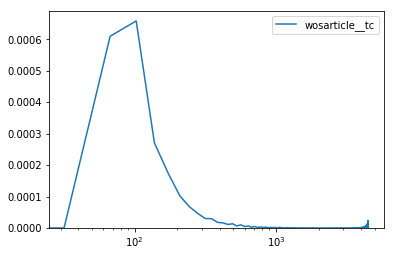

In [65]:
sns.kdeplot(
    tcs['wosarticle__tc'],
    bw='scott'
)
plt.xscale('log')
plt.show()

In [80]:
from scipy import stats
x = range(0,6000)

ip_density = stats.gaussian_kde(iptcs['wosarticle__tc']).pdf(x)
all_density = stats.gaussian_kde(tcs['wosarticle__tc']).pdf(x)


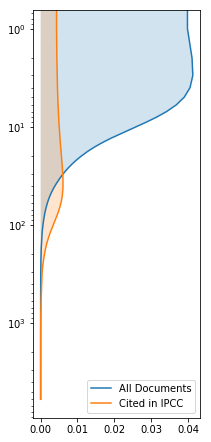

In [102]:
plt.rcParams["figure.figsize"] = [3,7.5]

fig, ax = plt.subplots()

p1, = ax.plot(all_density,x, label="All Documents")
ax.fill_betweenx(x,0,all_density,alpha=0.2)
p2, = ax.plot(ip_density,x, label="Cited in IPCC")
ax.fill_betweenx(x,0,ip_density,alpha=0.2)

plt.legend(handles=[p1,p2])

ax.invert_yaxis()

plt.yscale('log')

plt.show()